In [1]:
import pandas as pd
path="../dataset"
data = pd.read_csv(path + '/CAvideos.csv')
data.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...


In [2]:
import json

category_dict={}
country='CA'
with open(f'../dataset/{country}_category_id.json', 'r') as file:
        d = json.load(file)
        category_dict[country]={}
        for item in d['items']:
            category_dict[int(item['id'])]=item['snippet']['title']
category_dict

{'CA': {},
 1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

In [3]:
data['category_name'] = data['category_id'].map(category_dict).fillna('Unknown')

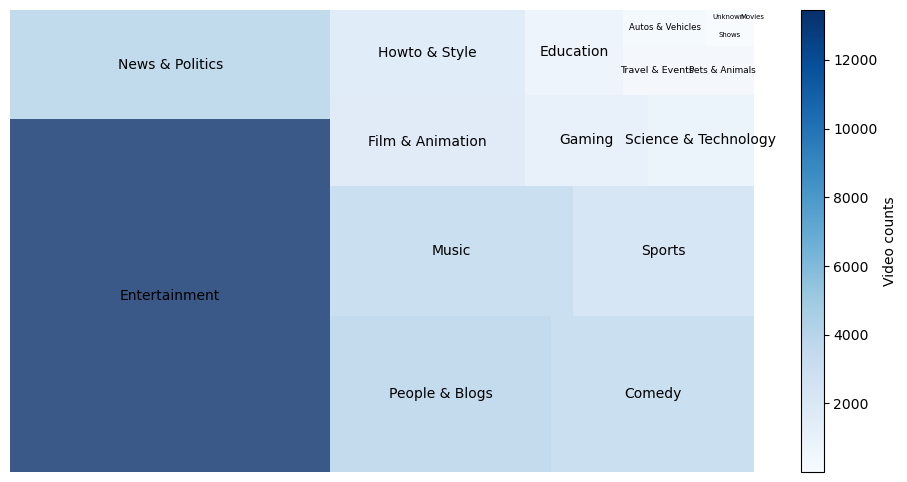

In [4]:
import matplotlib.pyplot as plt
import squarify

# 统计每个类别的数量
category_counts = data['category_name'].value_counts()

# 创建颜色映射（蓝色渐变）
cmap = plt.cm.Blues  # 使用蓝色渐变
norm = plt.Normalize(vmin=category_counts.min(), vmax=category_counts.max())  # 数据归一化

# 创建绘图
fig, ax = plt.subplots(figsize=(12, 6))

# 绘制树图
squarify.plot(
    sizes=category_counts.values,
    # label=category_counts.index,
    color=plt.cm.Blues(category_counts.values / category_counts.values.max()),
    alpha=0.8,
    ax=ax
)

# 获取矩形的坐标和大小
rects = ax.patches

# 设置最小矩形宽度或高度，若矩形小于该值则不显示文本
min_size = 140  # 可以根据实际情况调整

# 遍历所有矩形，如果矩形面积大于指定阈值则显示文本
for rect, label in zip(rects, category_counts.index):
    width, height = rect.get_width(), rect.get_height()
    fontsize= 10 if width*height>min_size else max(5,width*height/min_size*10)
    # if width * height > min_size:
    x = rect.get_x() + width / 2  # x 坐标：矩形中心
    y = rect.get_y() + height / 2  # y 坐标：矩形中心
    ax.text(x, y, label, ha="center", va="center", fontsize=fontsize)


# 添加标题
# plt.title("Treemap of Different Category Video Counts")

# 隐藏坐标轴
plt.axis('off')


# Create a colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical')
cbar.set_label('Video counts')
# cbar
# Show the plot
plt.show()


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

data['text'] = data['title'] + ' ' + data['tags']
vectorizer = CountVectorizer(stop_words='english', max_features=100)
X = vectorizer.fit_transform(data['text'].fillna(''))


In [6]:
word_freq = np.asarray(X.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()
freq_df = pd.DataFrame({'word': words, 'frequency': word_freq}).sort_values(by='frequency', ascending=False)

In [7]:
freq_df.head(10)

,word,frequency
4,2018,15955
59,news,10220
58,new,9662
91,video,8228
27,funny,8204
88,trump,7279
94,vs,7214
76,songs,7042
3,2017,6812
20,episode,6808


/var/folders/lg/2b6kvsmj7qx7b5xnn3984f680000gn/T/ipykernel_16270/513905447.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data=top_20_words, palette='Blues_d')


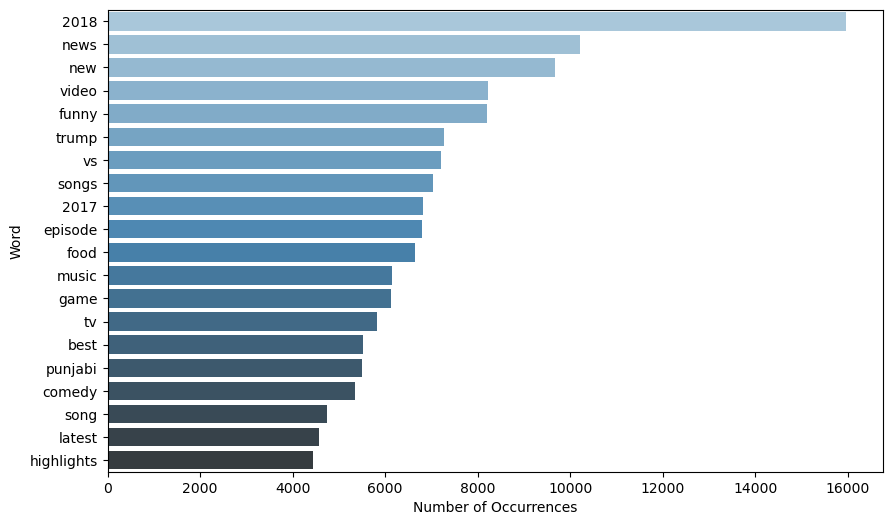

In [8]:
import seaborn as sns
top_20_words = freq_df.nlargest(20, 'frequency')

# 创建条形图
plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='word', data=top_20_words, palette='Blues_d')

# 设置标题和标签
# plt.title('Top 20 Most Frequent Words')
plt.xlabel('Number of Occurrences')
plt.ylabel('Word')

# 显示图形
plt.show()

In [9]:
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
y = data['views']

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

KeyboardInterrupt: 

In [ ]:
feature_importances = pd.DataFrame({
    'word': X_df.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importances.head(20))

             word  importance
61       official    0.090817
70          rhett    0.064870
95            war    0.051872
91          video    0.051649
58            new    0.039501
47           link    0.038401
79        stephen    0.037600
81          super    0.033172
87        trailer    0.031000
56          music    0.029190
3            2017    0.028721
75           song    0.025254
98        youtube    0.024631
50           love    0.024302
97          world    0.023618
4            2018    0.020401
54          movie    0.018075
19  entertainment    0.017308
27          funny    0.017181
49          logan    0.015951


In [28]:
y = data['category_name']

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

data['text'] = data['title'] + ' ' + data['tags']+ ' ' + data['description']
data = data.dropna(subset=['text', 'category_id'])

X = data['text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [30]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE

model = LogisticRegression(max_iter=1000, random_state=42)
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_tfidf, y_train)

model.fit(X_train_balanced, y_train_balanced)

from sklearn.metrics import classification_report, accuracy_score
y_pred = model.predict(X_test_tfidf)
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


Classification Report:
                      precision    recall  f1-score   support

    Autos & Vehicles       0.62      0.89      0.73        63
              Comedy       0.75      0.82      0.78       767
           Education       0.67      0.91      0.77       205
       Entertainment       0.92      0.69      0.79      2579
    Film & Animation       0.65      0.80      0.72       393
              Gaming       0.63      0.84      0.72       262
       Howto & Style       0.81      0.91      0.85       379
               Music       0.88      0.91      0.89       755
     News & Politics       0.82      0.84      0.83       764
      People & Blogs       0.62      0.67      0.65       749
      Pets & Animals       0.88      0.96      0.92        83
Science & Technology       0.75      0.87      0.81       252
               Shows       0.38      1.00      0.55        23
              Sports       0.89      0.93      0.91       553
     Travel & Events       0.81      0.95     

In [34]:
y_train_balanced.value_counts()

category_name
Entertainment           10594
Gaming                  10594
Unknown                 10594
Shows                   10594
Autos & Vehicles        10594
Pets & Animals          10594
Travel & Events         10594
Science & Technology    10594
Education               10594
People & Blogs          10594
Comedy                  10594
Music                   10594
Sports                  10594
Howto & Style           10594
Film & Animation        10594
News & Politics         10594
Movies                  10594
Name: count, dtype: int64

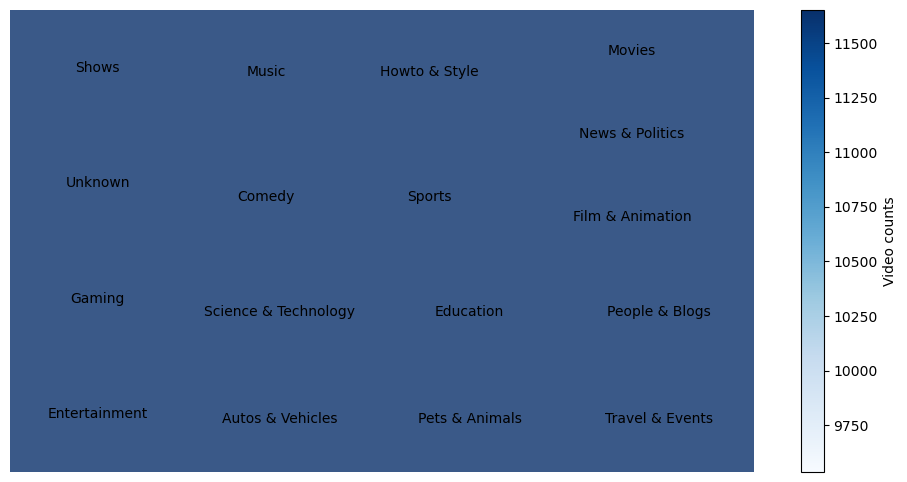

In [35]:
import matplotlib.pyplot as plt
import squarify

# 统计每个类别的数量
category_counts = y_train_balanced.value_counts()

# 创建颜色映射（蓝色渐变）
cmap = plt.cm.Blues  # 使用蓝色渐变
norm = plt.Normalize(vmin=category_counts.min(), vmax=category_counts.max())  # 数据归一化

# 创建绘图
fig, ax = plt.subplots(figsize=(12, 6))

# 绘制树图
squarify.plot(
    sizes=category_counts.values,
    # label=category_counts.index,
    color=plt.cm.Blues(category_counts.values / category_counts.values.max()),
    alpha=0.8,
    ax=ax
)

# 获取矩形的坐标和大小
rects = ax.patches

# 设置最小矩形宽度或高度，若矩形小于该值则不显示文本
min_size = 140  # 可以根据实际情况调整

# 遍历所有矩形，如果矩形面积大于指定阈值则显示文本
for rect, label in zip(rects, category_counts.index):
    width, height = rect.get_width(), rect.get_height()
    fontsize= 10 if width*height>min_size else max(5,width*height/min_size*10)
    # if width * height > min_size:
    x = rect.get_x() + width / 2  # x 坐标：矩形中心
    y = rect.get_y() + height / 2  # y 坐标：矩形中心
    ax.text(x, y, label, ha="center", va="center", fontsize=fontsize)


# 添加标题
# plt.title("Treemap of Different Category Video Counts")

# 隐藏坐标轴
plt.axis('off')


# Create a colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical')
cbar.set_label('Video counts')
# cbar
# Show the plot
plt.show()


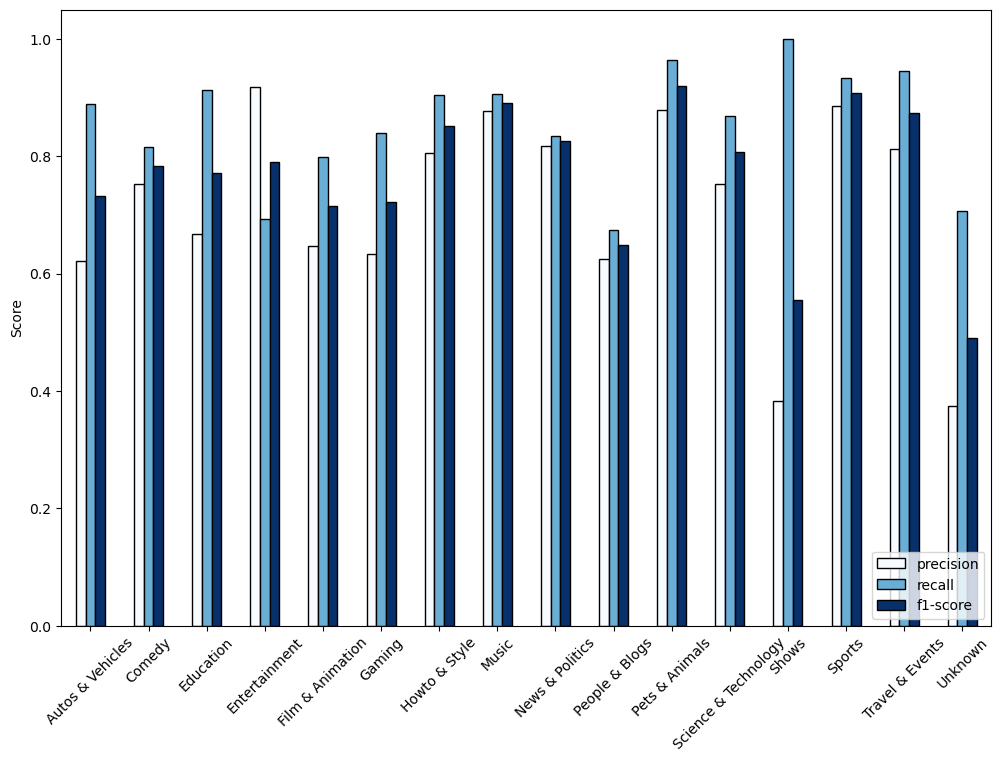

In [32]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report

# 获取分类报告并转换为 DataFrame
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# 提取每个类别的 Precision、Recall 和 F1-Score
categories = df_report.index[:-3]  # 排除 'accuracy', 'macro avg', 'weighted avg'
metrics = ['precision', 'recall', 'f1-score']

# 可视化
df_report.loc[categories, metrics].plot(kind='bar', figsize=(12, 8), colormap='Blues', edgecolor='black')
# plt.title('Classification Metrics by Category')
plt.ylabel('Score')
# plt.xlabel('Category')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()


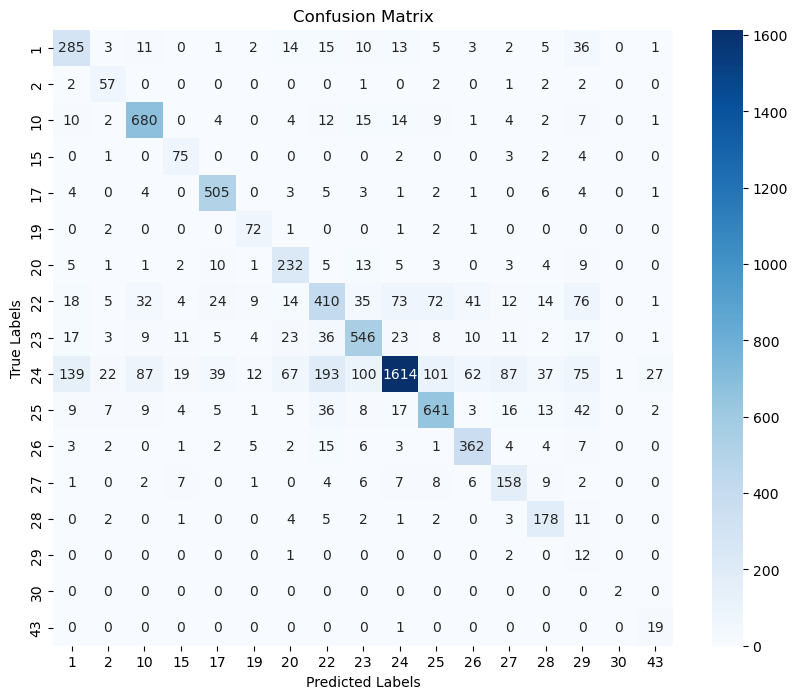

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)
categories = model.classes_  # 类别名称，确保与类别一致

# 可视化混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_balanced, y_train_balanced )

from sklearn.metrics import classification_report, accuracy_score
y_pred = model.predict(X_test_tfidf)
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, clf in models.items():
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Logistic Regression Accuracy: 0.75
Support Vector Machine Accuracy: 0.76
Naive Bayes Accuracy: 0.69
Random Forest Accuracy: 0.89
